# Mod 3 Final Project

by: Jeremy Owens, Georgina Sampson

In [151]:
#importing libraries to utilize in experiment
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import time
import copy
import statsmodels.formula.api as smf
%matplotlib inline

In [185]:
# reading in crime csv from denvergov.org (shortened slightly from 500K entries to 450K 
# entries to make GitHub happy)
crime_data = pd.read_csv('denver_data/crime_short.csv')

# reading in active mj business license csv from denvergov.org
dispensary_data = pd.read_csv('denver_data/marijuana_active_business_licenses.csv')

In [186]:
# initial crime dataframe exploration
print(len(crime_data))
crime_data.head()

450000


,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [187]:
# lower case all columns to make exploration and transformation easier 
crime_data.columns = [x.lower() for x in crime_data.columns]

In [188]:
# minimize data set to only include crimes, not traffic violations
crime_data = crime_data[crime_data.is_crime == 1]

In [189]:
# create new column for year of incident, according to 'reported_date'
crime_data['year'] = crime_data.reported_date.apply(lambda date: int(date.split()[0][-4:]))

In [190]:
# making a list of all offense type ids for type analysis
offense_type_ids = list(crime_data.groupby('offense_type_id').count().index)

In [191]:
# create lists for all violent type offenses and drug type offenses
# last list comprehension for violent is for two missed assault types from overall list
violent_list = [off for off in offense_type_ids if 'assault' in off] + \
                    [off for off in offense_type_ids if 'homicide' in off] + \
                    [off for off in offense_type_ids if 'robbery' in off] + \
                    [off for off in offense_type_ids if 'sex-aslt' in off] + \
                    ['agg-aslt-police-weapon', 'aslt-agg-police-gun']
violent_list.pop(violent_list.index('traf-vehicular-assault'))

drug_list = [off for off in offense_type_ids if 'drug' in off]

In [192]:
# given an offense, return if it's violent related, drug related, or other
def gen_offense_type(offense):
    if offense in violent_list:
        return 'violent'
    elif offense in drug_list:
        return 'drug'
    else:
        return 'other'

In [193]:
# make new column that calls gen_offense type to get crime type for further analysis
crime_data['gen_offense_type'] = crime_data.offense_type_id.apply(lambda offense: gen_offense_type(offense))

In [194]:
# eliminate unnecessary columns for ease of exploration/transformation
crime_data_short = crime_data.drop(['offense_code', 'offense_id', 'offense_code_extension', 'offense_type_id', 
                                    'offense_category_id', 'first_occurrence_date', 'last_occurrence_date', 
                                    'incident_address', 'geo_x', 'geo_y', 'geo_lon', 'geo_lat', 'district_id', 
                                    'precinct_id', 'is_crime', 'is_traffic', 'reported_date'], 
                                    axis=1)
crime_data_short.sample(10)

,incident_id,neighborhood_id,year,gen_offense_type
94455,2015137428,five-points,2015,other
329703,2015623609,villa-park,2015,violent
398776,2014408190,south-park-hill,2014,other
270297,201497510,sunnyside,2014,other
443174,20166001131,five-points,2016,other
403785,2014561187,cheesman-park,2014,other
64912,2014159806,five-points,2014,violent
106807,2015287047,westwood,2015,other
5851,2018168492,east-colfax,2018,violent
180371,2016627563,washington-virginia-vale,2016,other


In [195]:
# grouping crime data by neighborhood and year, counting each offense type in that year
crime_data_grouped = crime_data_short.groupby(['neighborhood_id', 'year', 'gen_offense_type']).count()
crime_data_grouped = crime_data_grouped.reset_index()
crime_data_grouped.sample(10)

,neighborhood_id,year,gen_offense_type,incident_id
847,north-park-hill,2015,violent,48
463,five-points,2018,violent,347
1044,speer,2015,other,790
1348,westwood,2015,drug,105
1316,west-colfax,2016,other,1226
48,baker,2018,drug,47
1151,university-hills,2015,drug,23
134,berkeley,2016,violent,60
540,hale,2014,other,334
612,harvey-park-south,2014,other,496


In [196]:
# lower case columns, subset dataframe to only the columns we care about
dispensary_data.columns = [x.lower().replace(' ', '_') for x in dispensary_data.columns]
dispensary_data = dispensary_data[['business_file_number', 'license_type', 'facility_zip_code']]
dispensary_data.head(10)

,business_file_number,license_type,facility_zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204.0
1,2018-BFN-0000285,Retail Marij Opt. Prem. Cultiv,80216.0
2,2018-BFN-0000461,Retail Marijuana Store,80239.0
3,2014-BFN-0004431,Med Marijuana Opt Prem Cultiv,80216.0
4,2014-BFN-0004811,Retail Marijuana Store,80216.0
5,2013-BFN-1065013,Med Marijuana Opt Prem Cultiv,80216.0
6,2013-BFN-1066526,Med Marijuana Inf Prod Manuf,80216.0
7,2013-BFN-1066097,Med Marijuana Inf Prod Manuf,NaN
8,2013-BFN-1069615,Retail Marijuana Store,80210.0
9,2013-BFN-1069055,Retail Marijuana Store,80202.0


In [197]:
# drop all rows that have NaN values (since we need all the associated data in this subset)
# cast the zip code to an integer for future dataframe combination ease
dispensary_data.dropna(inplace=True)
dispensary_data = dispensary_data.astype({'facility_zip_code': 'int64'})
dispensary_data.rename({'facility_zip_code': 'zip_code'}, axis=1, inplace=True)
dispensary_data.head()

,business_file_number,license_type,zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204
1,2018-BFN-0000285,Retail Marij Opt. Prem. Cultiv,80216
2,2018-BFN-0000461,Retail Marijuana Store,80239
3,2014-BFN-0004431,Med Marijuana Opt Prem Cultiv,80216
4,2014-BFN-0004811,Retail Marijuana Store,80216


In [18]:
# make new dataframe for where license types are retail or medical distribution centers
# these are the only types of dispensaries in the scope of this experiment
stores_data = dispensary_data[dispensary_data.license_type.isin(['Retail Marijuana Store', 
                                                                 'Medical Marijuana Center'])]
print(len(stores_data))
stores_data.head(10)

345


,business_file_number,license_type,zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204
2,2018-BFN-0000461,Retail Marijuana Store,80239
4,2014-BFN-0004811,Retail Marijuana Store,80216
8,2013-BFN-1069615,Retail Marijuana Store,80210
9,2013-BFN-1069055,Retail Marijuana Store,80202
11,2016-BFN-0004809,Retail Marijuana Store,80223
12,2015-BFN-0002256,Medical Marijuana Center,80211
19,2018-BFN-0007446,Retail Marijuana Store,80205
20,2010-BFN-1045700,Medical Marijuana Center,80209
21,2010-BFN-1048389,Medical Marijuana Center,80216


In [19]:
# number of medical or retail stores by zip code
store_count = stores_data.groupby('zip_code')['business_file_number'].count()
store_count

zip_code
80123     2
80127     2
80202    13
80203    18
80204    25
80205    22
80206     5
80207     6
80209     8
80210    35
80211    20
80212     6
80214     2
80216    45
80218     6
80219    21
80220    15
80222     9
80223    39
80224    10
80231     4
80232     4
80236     2
80237     2
80239    20
80247     2
80249     2
Name: business_file_number, dtype: int64

In [20]:
# scraping the city-data site for Denver for all associated zip codes in Denver region
html_page = requests.get('http://www.city-data.com/zipmaps/Denver-Colorado.html')
soup = BeautifulSoup(html_page.content, 'html.parser')
zip_code_list = []
zip_codes = soup.find(class_="zip-codes").findAll('a', recursive=False)
for tag in zip_codes:
    zip_code_list.append(int(tag.text))
zip_code_list[:5]

In [23]:
# scraping city-data websites for detail zip code info to get all neighborhoods associated with
# each Denver zip code (for joining crime dataframe purposes)
zip_neighbor_dict = {}
for zip_code in zip_code_list:
    html_page = requests.get('http://www.city-data.com/zips/{}.html'.format(zip_code))
    soup = BeautifulSoup(html_page.content, 'html.parser')
    neighborhoods = []
    for a in soup.find_all('a'):
        # if statements clarify that it is part of the list of neighborhoods for that zip
        if 'neighborhood' in a.text:
            if a.text.split()[-1] == 'neighborhood':
                if len(a.text.split()) < 6:
                    # modifying add to list of neighborhoods to match crime dataframe
                    if 'Central Business District' in a.text:
                        neighborhood = 'cbd'
                    elif '(' in a.text:
                        neighborhood = '-'.join(a.text[:(a.text.index('(') - 1)].split()).lower()
                    else:
                        neighborhood = '-'.join(a.text.split()[:-1]).lower()
                    neighborhoods.append(neighborhood)
    zip_neighbor_dict.update({zip_code: neighborhoods})
    time.sleep(0.5)
    
zip_neighbor_dict

{80012: ['aurora-district', 'city-center'],
 80014: ['cherry-creek-district', 'kennedy'],
 80110: ['college-view',
  'fort-logan',
  'harvey-park-south',
  'overland',
  'south-platte',
  'southwest',
  'university',
  'wellshire'],
 80111: ['kennedy'],
 80123: ['fort-logan', 'marston', 'southwest'],
 80202: ['cbd',
  'central-platte-valley',
  'cbd',
  'five-points',
  'highland',
  'lower-downtown',
  'north-capitol-hill',
  'union-station'],
 80203: ['alamo-placita',
  'capitol-hill',
  'civic-center',
  'five-points',
  'golden-triangle',
  'north-capitol-hill',
  'speer',
  'uptown'],
 80204: ['auraria',
  'baker',
  'barnum',
  'barnum-west',
  'cbd',
  'civic-center',
  'colfax',
  'cbd',
  'golden-triangle',
  'lincoln-park',
  'lower-downtown',
  'sheridan-boulevard',
  'sloan-lake',
  'southwest',
  'sun-valley',
  'union-station',
  'valverde',
  'villa-park'],
 80205: ['ballpark',
  'city-park',
  'city-park-west',
  'clayton',
  'cole',
  'curtis-park',
  'five-points',
  

In [25]:
# making a deep copy of the dictionary made from scraping, so there is no need to
# rescrape all websites for data (which takes a while to run...)
zip_neighbor_dict_mod = copy.deepcopy(zip_neighbor_dict)

In [24]:
# get all neighborhoods that are a part of the crime dataframe
crime_neighborhoods = list(crime_data_short.neighborhood_id.unique())
sorted(crime_neighborhoods)[:5]

['athmar-park',
 'auraria',
 'baker',
 'barnum',
 'barnum-west',
 'bear-valley',
 'belcaro',
 'berkeley',
 'capitol-hill',
 'cbd',
 'chaffee-park',
 'cheesman-park',
 'cherry-creek',
 'city-park',
 'city-park-west',
 'civic-center',
 'clayton',
 'cole',
 'college-view-south-platte',
 'congress-park',
 'cory-merrill',
 'country-club',
 'dia',
 'east-colfax',
 'elyria-swansea',
 'five-points',
 'fort-logan',
 'gateway-green-valley-ranch',
 'globeville',
 'goldsmith',
 'hale',
 'hampden',
 'hampden-south',
 'harvey-park',
 'harvey-park-south',
 'highland',
 'hilltop',
 'indian-creek',
 'jefferson-park',
 'kennedy',
 'lincoln-park',
 'lowry-field',
 'mar-lee',
 'marston',
 'montbello',
 'montclair',
 'north-capitol-hill',
 'north-park-hill',
 'northeast-park-hill',
 'overland',
 'platt-park',
 'regis',
 'rosedale',
 'ruby-hill',
 'skyland',
 'sloan-lake',
 'south-park-hill',
 'southmoor-park',
 'speer',
 'stapleton',
 'sun-valley',
 'sunnyside',
 'union-station',
 'university',
 'universit

In [26]:
# eliminates all crimes from web scrape that are not in crime dataframe
for key, values in zip_neighbor_dict_mod.items():
    counter = 0
    list_len = len(values)
    if list_len == 0:
        continue
    else:
        while counter < list_len:
            if values[counter] not in crime_neighborhoods:
                del values[counter]
                list_len -= 1
            else:
                counter += 1
                
# removes repeat neighborhoods from dictionary from scrape
for key, values in zip_neighbor_dict_mod.items():
    values = list(set(values))
    zip_neighbor_dict_mod.update({key: values})
zip_neighbor_dict_mod

{80012: [],
 80014: ['kennedy'],
 80110: ['wellshire',
  'harvey-park-south',
  'university',
  'overland',
  'fort-logan'],
 80111: ['kennedy'],
 80123: ['marston', 'fort-logan'],
 80202: ['union-station',
  'cbd',
  'highland',
  'north-capitol-hill',
  'five-points'],
 80203: ['speer',
  'north-capitol-hill',
  'five-points',
  'civic-center',
  'capitol-hill'],
 80204: ['union-station',
  'villa-park',
  'sloan-lake',
  'cbd',
  'baker',
  'barnum',
  'sun-valley',
  'lincoln-park',
  'auraria',
  'civic-center',
  'barnum-west',
  'valverde'],
 80205: ['city-park-west',
  'whittier',
  'clayton',
  'city-park',
  'north-capitol-hill',
  'five-points',
  'cole',
  'skyland'],
 80206: ['city-park-west',
  'cherry-creek',
  'cheesman-park',
  'city-park',
  'country-club',
  'congress-park'],
 80207: ['north-park-hill',
  'south-park-hill',
  'northeast-park-hill',
  'stapleton'],
 80209: ['washington-park',
  'cherry-creek',
  'country-club',
  'speer',
  'belcaro',
  'washington-pa

In [27]:
# creating Pandas dataframe from web scrape
neighborhoods_df = pd.DataFrame.from_dict(zip_neighbor_dict_mod, orient='index')
neighborhoods_df.dropna(how='all', inplace=True)
neighborhoods_df = neighborhoods_df.reset_index()
neighborhoods_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11
0,80014,kennedy,None,None,None,None,None,None,None,None,None,None,None
1,80110,wellshire,harvey-park-south,university,overland,fort-logan,None,None,None,None,None,None,None
2,80111,kennedy,None,None,None,None,None,None,None,None,None,None,None
3,80123,marston,fort-logan,None,None,None,None,None,None,None,None,None,None
4,80202,union-station,cbd,highland,north-capitol-hill,five-points,None,None,None,None,None,None,None


In [28]:
# given a zip code, year, and crime type, returns the average number of crimes for that zip code
# across all neighborhoods assoiated with that zip code
def calc_crime(zip_code, year, crime_type):
    sum_of_crime = 0
    if crime_type == 'violent':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year) &
                                               (crime_data_grouped.gen_offense_type == 'violent')]['incident_id'].sum()
    elif crime_type == 'drug':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year) &
                                               (crime_data_grouped.gen_offense_type == 'drug')]['incident_id'].sum()
    elif crime_type == 'all':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year)]['incident_id'].sum()
            
    return int(round(sum_of_crime / len(zip_neighbor_dict_mod[zip_code]), 0))


In [29]:
# creating new columns for all, violent, and drug related crime (from crime dataframe)
# in 2014 and 2017 for each zip code
neighborhoods_df['2014_all_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'all'))
neighborhoods_df['2014_violent_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'violent'))
neighborhoods_df['2014_drug_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'drug'))

neighborhoods_df['2017_all_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'all'))
neighborhoods_df['2017_violent_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'violent'))
neighborhoods_df['2017_drug_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'drug'))


In [30]:
# removes neighborhoods from dataframe, resets index for ease of use
neighborhoods_df = neighborhoods_df.drop(range(12), axis=1)
neighborhoods_df.rename({'index': 'zip_code'}, axis=1, inplace=True)
neighborhoods_df.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime
0,80014,250,41,3,335,51,9
1,80110,389,45,19,388,38,20
2,80111,250,41,3,335,51,9
3,80123,296,30,4,417,53,4
4,80202,2012,246,205,2078,275,181


In [31]:
# adds dispensary count for each zip to dataframe, all NaN values set to 0
# (as there are no dispensaries in those zip codes on record)
final_df = neighborhoods_df.join(store_count, on='zip_code')
final_df.fillna(0, inplace=True)
final_df.rename({'business_file_number': 'dispensary_count'}, axis=1, inplace=True)
final_df = final_df.astype({'dispensary_count': 'int64'})
final_df.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count
0,80014,250,41,3,335,51,9,0
1,80110,389,45,19,388,38,20,0
2,80111,250,41,3,335,51,9,0
3,80123,296,30,4,417,53,4,2
4,80202,2012,246,205,2078,275,181,13
5,80203,1721,232,156,2085,273,250,18
6,80204,1102,130,92,1086,138,81,25
7,80205,930,122,80,1024,141,91,22
8,80206,550,53,17,555,57,15,5
9,80207,993,88,40,1036,97,46,6


## Scraping for median income and population per zip-code

In [32]:
# soup construction for web scraping income and population data for each zip code
html_page = requests.get('http://www.city-data.com/zipmaps/Denver-Colorado.html')
soup = BeautifulSoup(html_page.content, 'html.parser')

In [36]:
# function to scrape for median income in each zip code
def medianIncomePerYear(year, html):
    for zipStatistics in html.findAll('div', class_="data-block"):
        # <strong>Zip code 80014 statistics:</strong>
        strong = zipStatistics.find('strong').text
        zipCode = int(re.match(r"(Zip code )(\d{5})( statistics:)", strong).groups()[1])
        median_household_income = 0
        for bold_tag in zipStatistics.findAll('b'):
            if f"Estimated median household income in {year}:" in bold_tag.text:
                income_string = bold_tag.nextSibling
                income_string = income_string.strip()
                income_string = re.sub("\$", "", income_string)
                income_string = re.sub(",","", income_string)
                median_household_income = int(income_string)
        yield {zipCode: median_household_income}
medianIncomePerYear2016 = [zipCode for zipCode in medianIncomePerYear(2016, soup)]

# takes individual dictionaries and turns them into one giant dictionary
medianIncomePerYear2016_fulldict = {}
for zip_code_income in medianIncomePerYear2016:
    for key, val in zip_code_income.items():
        if val == 0:
            continue
        else:
            medianIncomePerYear2016_fulldict.update({key: val})
medianIncomePerYear2016_fulldict

{80012: 47637,
 80014: 54779,
 80110: 50448,
 80111: 101311,
 80123: 77226,
 80202: 73743,
 80203: 49252,
 80204: 36586,
 80205: 60235,
 80206: 67196,
 80207: 67419,
 80209: 89207,
 80210: 80986,
 80211: 66879,
 80212: 67427,
 80214: 39190,
 80216: 45290,
 80218: 55713,
 80219: 43188,
 80220: 71270,
 80221: 52867,
 80222: 52772,
 80223: 45186,
 80224: 53003,
 80226: 57716,
 80227: 64022,
 80230: 80495,
 80231: 53219,
 80232: 65087,
 80235: 57765,
 80236: 53593,
 80237: 69327,
 80239: 52513,
 80246: 47818,
 80249: 73623}

In [37]:
# function to scrape for population in each zip code
def Population(year, html):
    for zipStatistics in html.findAll('div', class_="data-block"):
        # <strong>Zip code 80014 statistics:</strong>
        strong = zipStatistics.find('strong').text
        zipCode = int(re.match(r"(Zip code )(\d{5})( statistics:)", strong).groups()[1])
        pop = 0
        for bold_tag in zipStatistics.findAll('b'):
            if f"Estimated zip code population in {year}:" in bold_tag.text:
                income_string = bold_tag.nextSibling
                income_string = income_string.strip()
                income_string = re.sub("\$", "", income_string)
                income_string = re.sub(",","", income_string)
                pop = int(income_string)
        yield {zipCode: pop}
pop2016 = [zipCode for zipCode in Population(2016, soup)]

# takes individual dictionaries and turns them into one giant dictionary
pop2016_fulldict = {}
for zip_code_pop in pop2016:
    for key, val in zip_code_pop.items():
        if val == 0:
            continue
        else:
            pop2016_fulldict.update({key: val})
pop2016_fulldict

{80012: 51510,
 80014: 39054,
 80110: 22106,
 80111: 32382,
 80123: 46458,
 80202: 12824,
 80203: 20809,
 80204: 32769,
 80205: 33012,
 80206: 23852,
 80207: 25706,
 80209: 25608,
 80210: 36503,
 80211: 33735,
 80212: 19700,
 80214: 25614,
 80216: 12640,
 80218: 19055,
 80219: 68307,
 80220: 36227,
 80221: 41064,
 80222: 21577,
 80223: 19956,
 80224: 19338,
 80226: 32775,
 80227: 35484,
 80230: 8612,
 80231: 36425,
 80232: 22719,
 80235: 8015,
 80236: 18749,
 80237: 20158,
 80239: 46496,
 80246: 13474,
 80249: 29440}

In [38]:
# joining income and population data into dataframe
final_df_income = final_df.join(pd.DataFrame.from_dict(medianIncomePerYear2016_fulldict, orient='index'), 
                                on='zip_code')
final_df_income = final_df_income.rename({0: 'median_income'}, axis=1)

final_df_income_pop = final_df_income.join(pd.DataFrame.from_dict(pop2016_fulldict, orient='index'), 
                                on='zip_code')
final_df_income_pop = final_df_income_pop.rename({0: 'population'}, axis=1)
final_df_income_pop.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population
0,80014,250,41,3,335,51,9,0,54779,39054
1,80110,389,45,19,388,38,20,0,50448,22106
2,80111,250,41,3,335,51,9,0,101311,32382
3,80123,296,30,4,417,53,4,2,77226,46458
4,80202,2012,246,205,2078,275,181,13,73743,12824
5,80203,1721,232,156,2085,273,250,18,49252,20809
6,80204,1102,130,92,1086,138,81,25,36586,32769
7,80205,930,122,80,1024,141,91,22,60235,33012
8,80206,550,53,17,555,57,15,5,67196,23852
9,80207,993,88,40,1036,97,46,6,67419,25706


In [66]:
# fuction for classifying a value engineered variable (econ_status) based on being in 1st quartile or
# 4th quartile
def econ_status(income):
    if income <= final_df_income_pop.median_income.quantile([0.25]).sum():
        return 'low'
    elif income >= final_df_income_pop.median_income.quantile([0.75]).sum():
        return 'high'
    else:
        return 'middle'

In [67]:
# adds a column for ratio of dispensaries to every 1K people in that zip code
final_df_income_pop['store_per_1Kpeople'] = round(final_df_income_pop.dispensary_count / 
                                                  (final_df_income_pop.population / 1000), 4)

# classifies zip code as low, middle, or high income, based on quartile ranges
final_df_income_pop['neighborhood_econ_status'] = final_df_income_pop.median_income.apply(lambda income:
                                                                                                econ_status(income))
final_df_income_pop.head(10)

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high
5,80203,1721,232,156,2085,273,250,18,49252,20809,0.8650,low
6,80204,1102,130,92,1086,138,81,25,36586,32769,0.7629,low
7,80205,930,122,80,1024,141,91,22,60235,33012,0.6664,middle
8,80206,550,53,17,555,57,15,5,67196,23852,0.2096,middle
9,80207,993,88,40,1036,97,46,6,67419,25706,0.2334,middle


## Putting our data into a SQL database

In [80]:
# open connection, init cursor
conn = sqlite3.connect("database.sqlite")
c = conn.cursor()

In [81]:
# adds data to sql database
final_df_income_pop.set_index('zip_code').to_sql('zip_code_statistics', conn, if_exists='replace')

In [82]:
# testing that data was entered properly
pd.read_sql_query('''SELECT * FROM zip_code_statistics LIMIT 5''', conn)

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high


In [83]:
# close cursor and connection
c.close()
conn.close()

In [110]:
# takes log of violent and drug related crime to shift to a more normally distributed data set
final_df_income_pop['violent_log_2017'] = np.log(final_df_income_pop['2017_violent_crime'])
final_df_income_pop['drug_log_2017'] = np.log(final_df_income_pop['2017_drug_crime'])
final_df_income_pop.head(10)

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status,violent_log_2017,drug_log_2017
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle,3.931826,2.197225
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low,3.637586,2.995732
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high,3.931826,2.197225
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high,3.970292,1.386294
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high,5.616771,5.198497
5,80203,1721,232,156,2085,273,250,18,49252,20809,0.8650,low,5.609472,5.521461
6,80204,1102,130,92,1086,138,81,25,36586,32769,0.7629,low,4.927254,4.394449
7,80205,930,122,80,1024,141,91,22,60235,33012,0.6664,middle,4.948760,4.510860
8,80206,550,53,17,555,57,15,5,67196,23852,0.2096,middle,4.043051,2.708050
9,80207,993,88,40,1036,97,46,6,67419,25706,0.2334,middle,4.574711,3.828641


In [93]:
# function for making a formula to pass to ols regression utility
def make_formula(dv, iv):
    string = dv + '~' + str(iv[0])
    if len(iv) > 1:
        for i in range(1, len(iv)):
            string += '+' + str(iv[i])
    return string

In [168]:
# formula: dv is violent_log, iv is proportion of stores to people
formula = make_formula('violent_log_2017', ['store_per_1Kpeople'])
# dataframe should only be low income zip codes
df = final_df_income_pop[final_df_income_pop.neighborhood_econ_status == 'low']

#running the ols model
model = smf.ols(formula=formula, data=df).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       violent_log_2017   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.053
Date:                Tue, 16 Jul 2019   Prob (F-statistic):              0.344
Time:                        09:33:00   Log-Likelihood:                -6.9917
No. Observations:                   8   AIC:                             17.98
Df Residuals:                       6   BIC:                             18.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5464      0.313     14.516      0.000       3.780       5.313
store_per_1Kpeople     0.2136      0.208      1.026      0.344      -0.296       0.723
==============================================================================
Omnibus:                        0.224   Durbin-Watson:                   2.589
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.375
Skew:                           0.130   Prob(JB):                        0.829
Kurtosis:                       1.972   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
# subsetting dataframe for violent_log and proportion of stores to people only for low income zip codes
violent_dispensary_2017 = df.sort_values('violent_log_2017')[['violent_log_2017', 
                                                              'store_per_1Kpeople']].reset_index()
violent_dispensary_2017.drop('index', axis=1, inplace=True)
violent_dispensary_2017

,violent_log_2017,store_per_1Kpeople
0,3.637586,0.0000
1,4.262680,0.0000
2,4.382027,1.9543
3,4.532599,0.3074
4,4.927254,0.7629
5,5.278115,3.5601
6,5.424950,0.4301
7,5.609472,0.8650


<function matplotlib.pyplot.show(*args, **kw)>

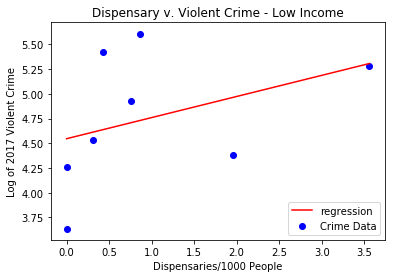

In [173]:
plt.scatter(violent_dispensary_2017.store_per_1Kpeople, violent_dispensary_2017.violent_log_2017, 
            c='blue', label='Crime Data')
plt.plot([0, 3.5601], [4.5464, (.2136*3.5601 + 4.5464)], c='red', label='regression')
plt.xlabel('Dispensaries/1000 People')
plt.ylabel('Log of 2017 Violent Crime')
plt.title('Dispensary v. Violent Crime - Low Income')
plt.legend(loc='lower right')
plt.show

In [160]:
# formula: dv is violent_log, iv is proportion of stores to people
formula = make_formula('drug_log_2017', ['store_per_1Kpeople'])
# dataframe should only be low income zip codes
df = final_df_income_pop[final_df_income_pop.neighborhood_econ_status == 'low']

model = smf.ols(formula=formula, data=final_df_income_pop).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          drug_log_2017   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     9.831
Date:                Tue, 16 Jul 2019   Prob (F-statistic):            0.00411
Time:                        09:23:41   Log-Likelihood:                -36.801
No. Observations:                  29   AIC:                             77.60
Df Residuals:                      27   BIC:                             80.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.1348      0.201     15.634      0.000       2.723       3.546
store_per_1Kpeople     0.7238      0.231      3.136      0.004       0.250       1.197
==============================================================================
Omnibus:                        0.623   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.716
Skew:                           0.270   Prob(JB):                        0.699
Kurtosis:                       2.452   Cond. No.                         1.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
# subsetting dataframe for drug_log and proportion of stores to people only for low income zip codes
drug_dispensary_2017 = df.sort_values('drug_log_2017')[['drug_log_2017', 
                                                        'store_per_1Kpeople']].reset_index()
drug_dispensary_2017.drop('index', axis=1, inplace=True)
drug_dispensary_2017

,drug_log_2017,store_per_1Kpeople
0,2.995732,0.0000
1,3.258097,0.0000
2,3.891820,0.3074
3,3.988984,1.9543
4,4.394449,0.7629
5,4.564348,0.4301
6,4.948760,3.5601
7,5.521461,0.8650


<function matplotlib.pyplot.show(*args, **kw)>

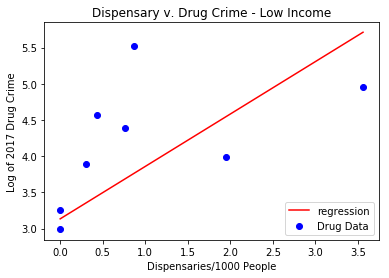

In [174]:
plt.scatter(drug_dispensary_2017.store_per_1Kpeople, drug_dispensary_2017.drug_log_2017, 
            c='blue', label='Drug Data')
plt.plot([0, 3.5601], [3.1348, (.7238*3.5601 + 3.1348)], c='red', label='regression')
plt.xlabel('Dispensaries/1000 People')
plt.ylabel('Log of 2017 Drug Crime')
plt.title('Dispensary v. Drug Crime - Low Income')
plt.legend(loc='lower right')
plt.show

# Working Zone

In [ ]:
print(len(crime_data))
crime_data.isna().sum()

In [ ]:
print(len(crime_data))
crime_data.sample(10)

In [ ]:
html_page = requests.get('http://www.city-data.com/zips/{}.html'.format(80202))
soup = BeautifulSoup(html_page.content, 'html.parser')
neighborhoods = []
for a in soup.find_all('a'):
    if 'neighborhood' in a.text:
        if a.text.split()[-1] == 'neighborhood':
            if len(a.text.split()) < 6:
                if 'Central Business District' in a.text:
                    neighborhood = 'cbd'
                elif '(' in a.text:
                    neighborhood = '-'.join(a.text[:(a.text.index('(') - 1)].split()).lower()
                else:
                    neighborhood = '-'.join(a.text.split()[:-1]).lower()
                neighborhoods.append(neighborhood)
neighborhoods

In [ ]:
neighborhoods_to_analyze = {}
for key, val in initial_neighborhood_counts.items():
    if val > 1:
        like_neighborhoods = []
        for key2, val2 in zip_neighbor_dict_mod.items():
             if key in val2:
                    like_neighborhoods.append(key2)
        neighborhoods_to_analyze.update({key: like_neighborhoods})
neighborhoods_to_analyze

In [ ]:
violent_data = crime_data[crime_data['gen_offense_type'] == 'violent']
drug_data = crime_data[crime_data['gen_offense_type'] == 'drug']

In [16]:
neighborhoods_to_analyze = {}
for key, val in initial_neighborhood_counts.items():
    if val > 1:
        like_neighborhoods = []
        for key2, val2 in zip_neighbor_dict_mod.items():
             if key in val2:
                    like_neighborhoods.append(key2)
        neighborhoods_to_analyze.update({key: like_neighborhoods})
neighborhoods_to_analyze

NameError: name 'initial_neighborhood_counts' is not defined

In [ ]:
offense_data.head(10)

In [ ]:
offense_data.groupby('OFFENSE_CATEGORY_ID')['OFFENSE_CODE'].count()

In [ ]:
print(len(dispensary_data))
dispensary_data.sample(10)

In [ ]:
dispensary_data.groupby('Trade Name').count()

In [ ]:
dispensary_data[dispensary_data['Trade Name'] == '1136 YUMA']